## **2.3 Question formulation**

### **Import Libraries**

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display

### **Load dataset**

In [130]:
# Load the dataset
Amazon_books = pd.read_csv('data/final_book_dataset_kaggle2.csv')

rows, cols = Amazon_books.shape
total_size = Amazon_books.memory_usage(deep=True).sum() / (1024 * 1024) # Size in MB

# Basic Information
print(f"Total Rows: {rows}")
print(f"Total Columns: {cols}")

# In ra 5 dòng đầu của bộ dữ liệu
display(Amazon_books.head())

Total Rows: 830
Total Columns: 19


,title,author,price,price (including used books),pages,avg_reviews,n_reviews,star5,star4,star3,star2,star1,dimensions,weight,language,publisher,ISBN_13,link,complete_link
0,Data Analysis Using R (Low Priced Edition): A ...,[ Dr Dhaval Maheta],6.75,6.75,500,4.4,23,55%,39%,6%,NaN,NaN,8.5 x 1.01 x 11 inches,2.53 pounds,English,"Notion Press Media Pvt Ltd (November 22, 2021)",978-1685549596,/Data-Analysis-Using-Low-Priced/dp/1685549594/...,https://www.amazon.com/Data-Analysis-Using-Low...
1,Head First Data Analysis: A learner's guide to...,NaN,33.72,21.49 - 33.72,484,4.3,124,61%,20%,9%,4%,6%,8 x 0.98 x 9.25 inches,1.96 pounds,English,"O'Reilly Media; 1st edition (August 18, 2009)",978-0596153939,/Head-First-Data-Analysis-statistics/dp/059615...,https://www.amazon.com/Head-First-Data-Analysi...
2,Guerrilla Data Analysis Using Microsoft Excel:...,"[ Oz du Soleil, and , Bill Jelen]",32.07,32.07,274,4.7,10,87%,13%,NaN,NaN,NaN,8.25 x 0.6 x 10.75 inches,1.4 pounds,English,"Holy Macro! Books; Third edition (August 1, 2022)",978-1615470747,/Guerrilla-Analysis-Using-Microsoft-Excel/dp/1...,https://www.amazon.com/Guerrilla-Analysis-Usin...
3,Python for Data Analysis: Data Wrangling with ...,[ William McKinney],53.99,53.99,547,4.6,"1,686",75%,16%,5%,2%,2%,7 x 1.11 x 9.19 inches,1.47 pounds,English,"O'Reilly Media; 2nd edition (November 14, 2017)",978-1491957660,/Python-Data-Analysis-Wrangling-IPython/dp/149...,https://www.amazon.com/Python-Data-Analysis-Wr...
4,Excel Data Analysis For Dummies (For Dummies (...,[ Paul McFedries],24.49,24.49,368,3.9,12,52%,17%,10%,10%,10%,7.38 x 0.83 x 9.25 inches,1.3 pounds,English,"For Dummies; 5th edition (February 3, 2022)",978-1119844426,/Excel-Data-Analysis-Dummies-Computer/dp/11198...,https://www.amazon.com/Excel-Data-Analysis-Dum...


#### **Thuộc tính các cột**

In [131]:
# Bảng thống kê Dtype và Unique values
info_df = pd.DataFrame({
    'Dtype': Amazon_books.dtypes,
    'Unique Values': Amazon_books.nunique()
})

print(info_df)


                                Dtype  Unique Values
title                          object            830
author                         object            605
price                         float64            437
price (including used books)   object            523
pages                          object            376
avg_reviews                   float64             22
n_reviews                      object            289
star5                          object             67
star4                          object             48
star3                          object             33
star2                          object             20
star1                          object             19
dimensions                     object            540
weight                         object            273
language                       object             12
publisher                      object            694
ISBN_13                        object            503
link                           object         

#### **Các cột thuộc tính sử dụng và cột target**

In [132]:
#Các cột feature và target
features = [
    'pages', 'weight_lbs', 'volume',
    'avg_reviews', 'n_reviews', 
    'star5', 'star4', 'star3', 'star2', 'star1'
]
target = 'price'

#### **Xử lý các cột đặc biệt gồm weight và dimensions**

In [133]:
# --- 1. XỬ LÝ CỘT WEIGHT (Chuẩn hóa về Pounds) ---
def clean_weight(value):
    if pd.isna(value) or value == 'unknown':
        return np.nan
    
    value = str(value).lower()
    numbers = re.findall(r"\d*\.?\d+", value)
    
    if not numbers:
        return np.nan
    
    try:
        weight_num = float(numbers[0])
    except ValueError:
        # Nếu vẫn lỗi (ví dụ bắt được chuỗi lạ), trả về NaN thay vì dừng chương trình
        return np.nan
    
    # Logic chia đơn vị
    if 'ounce' in value:
        return weight_num / 16
    elif 'pound' in value or 'lbs' in value:
        return weight_num
    
    # Nếu chỉ có số mà không có đơn vị, ta tạm giả định là pounds (hoặc trả về NaN tùy bạn)
    # Ở đây mình return weight_num (giả định pounds) để giữ lại dữ liệu
    return weight_num

# Áp dụng hàm clean_weight
Amazon_books['weight_lbs'] = Amazon_books['weight'].apply(clean_weight)


# --- 2. XỬ LÝ CỘT DIMENSIONS (Tính Thể tích) ---
def calculate_volume(value):
    if pd.isna(value) or value == 'unknown':
        return np.nan
    
    value = str(value).lower()
    # Tìm 3 con số kích thước (L x W x H)
    dims = re.findall(r"[\d\.]+", value)
    
    if len(dims) >= 3:
        try:
            # Nhân 3 chiều lại: Dài * Rộng * Cao
            return float(dims[0]) * float(dims[1]) * float(dims[2])
        except ValueError:
            return np.nan
    return np.nan

# Áp dụng hàm tính thể tích (đơn vị cubic inches)
Amazon_books['volume'] = Amazon_books['dimensions'].apply(calculate_volume)

#### **Phần trăm bị thiếu**

In [134]:
# Kiểm tra phần trăm thiếu ở cột features và target
for col in features + [target]:
    missing_ratio = Amazon_books[col].isnull().mean()
    print(f"Missing Ratio in '{col}': {missing_ratio:.2%}")

Missing Ratio in 'pages': 10.24%
Missing Ratio in 'weight_lbs': 21.69%
Missing Ratio in 'volume': 22.41%
Missing Ratio in 'avg_reviews': 15.42%
Missing Ratio in 'n_reviews': 15.42%
Missing Ratio in 'star5': 15.42%
Missing Ratio in 'star4': 23.49%
Missing Ratio in 'star3': 33.25%
Missing Ratio in 'star2': 45.66%
Missing Ratio in 'star1': 60.48%
Missing Ratio in 'price': 13.01%


In [135]:
# Các kiểu dữ liệu của các cột
print(Amazon_books.dtypes)

title                            object
author                           object
price                           float64
price (including used books)     object
pages                            object
avg_reviews                     float64
n_reviews                        object
star5                            object
star4                            object
star3                            object
star2                            object
star1                            object
dimensions                       object
weight                           object
language                         object
publisher                        object
ISBN_13                          object
link                             object
complete_link                    object
weight_lbs                      float64
volume                          float64
dtype: object


In [136]:
# Xử lý phần trăm thiếu ở các cột quan trọng 
# Đối với cột price thay giá trị nan bằng unknown
Amazon_books['price'].fillna('unknown', inplace=True)

# Thay giá trị 0 với các cột
cols_fill_zero = [
    'n_reviews', 'avg_reviews', 
    'star5', 'star4', 'star3', 'star2', 'star1'
]

for col in cols_fill_zero:
    Amazon_books[col] = Amazon_books[col].fillna(0)

# Thay giá trị trung bình với các cột weight_lbs và volume
cols_fill_mean = ['weight_lbs', 'volume']
for col in cols_fill_mean:
    mean_value = Amazon_books[col].mean()
    Amazon_books[col] = Amazon_books[col].fillna(mean_value)
    
# Thay giá trị xuất hiện nhiều nhất với cột pages
most_frequent_pages = Amazon_books['pages'].mode()[0]
Amazon_books['pages'] = Amazon_books['pages'].fillna(most_frequent_pages)

In [137]:
for col in features + [target]:
    missing_ratio = Amazon_books[col].isnull().mean()
    print(f"Missing Ratio in '{col}': {missing_ratio:.2%}")

Missing Ratio in 'pages': 0.00%
Missing Ratio in 'weight_lbs': 0.00%
Missing Ratio in 'volume': 0.00%
Missing Ratio in 'avg_reviews': 0.00%
Missing Ratio in 'n_reviews': 0.00%
Missing Ratio in 'star5': 0.00%
Missing Ratio in 'star4': 0.00%
Missing Ratio in 'star3': 0.00%
Missing Ratio in 'star2': 0.00%
Missing Ratio in 'star1': 0.00%
Missing Ratio in 'price': 0.00%


In [138]:
# 1. Chọn các cột cần phân tích (bao gồm tất cả các sao)
cols_numeric = [
    'price', 'pages', 'weight_lbs', 'volume',
    'avg_reviews', 'n_reviews', 
    'star5', 'star4', 'star3', 'star2', 'star1'
]

# 2. XỬ LÝ LÀM SẠCH DỮ LIỆU
# Xử lý n_reviews (bỏ dấu phẩy)
if Amazon_books['n_reviews'].dtype == 'object':
    Amazon_books['n_reviews'] = Amazon_books['n_reviews'].astype(str).str.replace(',', '', regex=False)

# Xử lý TẤT CẢ các cột star (bỏ dấu %) 
star_cols = ['star5', 'star4', 'star3', 'star2', 'star1']

for col in star_cols:
    Amazon_books[col] = (
        Amazon_books[col]
        .astype(str)
        .str.replace('%', '', regex=False)
        .replace('nan', np.nan)   # tránh "nan" dạng string
        .astype(float)
        / 100
    )

# 3. Chuyển đổi toàn bộ sang dạng số
for col in cols_numeric:
    Amazon_books[col] = pd.to_numeric(Amazon_books[col], errors='coerce')
    


In [139]:
# Các kiểu dữ liệu của các cột
print(Amazon_books.dtypes)

title                            object
author                           object
price                           float64
price (including used books)     object
pages                           float64
avg_reviews                     float64
n_reviews                         int64
star5                           float64
star4                           float64
star3                           float64
star2                           float64
star1                           float64
dimensions                       object
weight                           object
language                         object
publisher                        object
ISBN_13                          object
link                             object
complete_link                    object
weight_lbs                      float64
volume                          float64
dtype: object


### **Question 1: Các thuộc tính vật lý và yếu tố thị trường nào (ví dụ: số trang, kích thước, trọng lượng, đánh giá) giải thích tốt nhất cho sự biến thiên của giá sách, và mức độ tác động của chúng so sánh với nhau như thế nào?**

- Việc xác định xem đặc tính vật lý (Physical) hay tín hiệu thị trường (Market-related) tác động mạnh hơn đến giá sẽ giúp hiểu rõ chiến lược định giá của các nhà xuất bản.

#### **Preprocessing**

In [140]:
Amazon_books_Q1 = Amazon_books.copy()

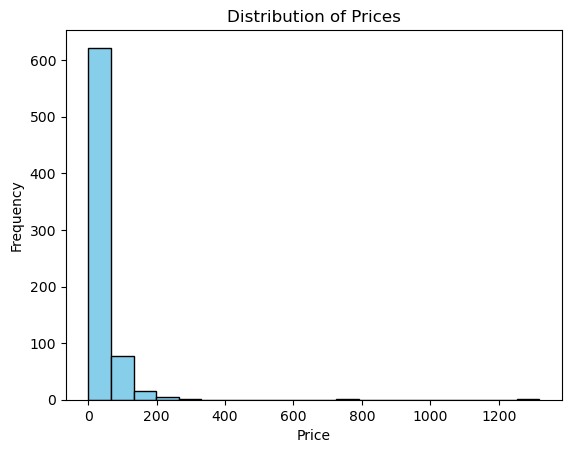

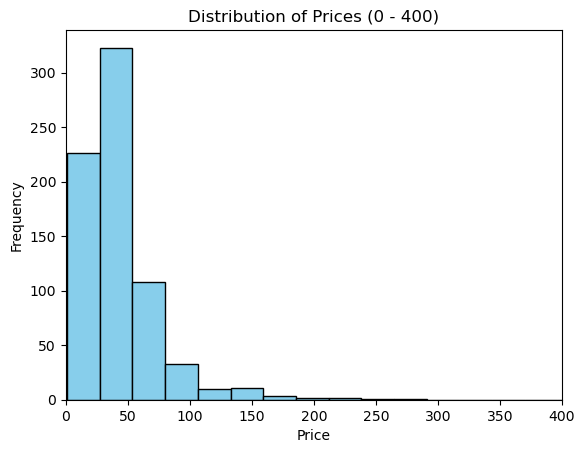

In [141]:
valid_prices = Amazon_books_Q1[Amazon_books_Q1['price'] != 'unknown']['price']

plt.hist(valid_prices, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Prices')
plt.show()


## Range 0 - 400
plt.hist(valid_prices, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Prices (0 - 400)')
plt.xlim(0, 400) 

plt.show()

In [142]:
valid_prices.mean()

46.491537396121885

- We can see majority of the books cost **less than $50**.

In [143]:
# In 5 dòng đầu của amazon_books_Q1 để kiểm tra kết quả
Amazon_books_Q1.head()

,title,author,price,price (including used books),pages,avg_reviews,n_reviews,star5,star4,star3,...,star1,dimensions,weight,language,publisher,ISBN_13,link,complete_link,weight_lbs,volume
0,Data Analysis Using R (Low Priced Edition): A ...,[ Dr Dhaval Maheta],6.75,6.75,500.0,4.4,23,0.55,0.39,0.06,...,0.00,8.5 x 1.01 x 11 inches,2.53 pounds,English,"Notion Press Media Pvt Ltd (November 22, 2021)",978-1685549596,/Data-Analysis-Using-Low-Priced/dp/1685549594/...,https://www.amazon.com/Data-Analysis-Using-Low...,2.53,94.43500
1,Head First Data Analysis: A learner's guide to...,NaN,33.72,21.49 - 33.72,484.0,4.3,124,0.61,0.20,0.09,...,0.06,8 x 0.98 x 9.25 inches,1.96 pounds,English,"O'Reilly Media; 1st edition (August 18, 2009)",978-0596153939,/Head-First-Data-Analysis-statistics/dp/059615...,https://www.amazon.com/Head-First-Data-Analysi...,1.96,72.52000
2,Guerrilla Data Analysis Using Microsoft Excel:...,"[ Oz du Soleil, and , Bill Jelen]",32.07,32.07,274.0,4.7,10,0.87,0.13,0.00,...,0.00,8.25 x 0.6 x 10.75 inches,1.4 pounds,English,"Holy Macro! Books; Third edition (August 1, 2022)",978-1615470747,/Guerrilla-Analysis-Using-Microsoft-Excel/dp/1...,https://www.amazon.com/Guerrilla-Analysis-Usin...,1.40,53.21250
3,Python for Data Analysis: Data Wrangling with ...,[ William McKinney],53.99,53.99,547.0,4.6,1686,0.75,0.16,0.05,...,0.02,7 x 1.11 x 9.19 inches,1.47 pounds,English,"O'Reilly Media; 2nd edition (November 14, 2017)",978-1491957660,/Python-Data-Analysis-Wrangling-IPython/dp/149...,https://www.amazon.com/Python-Data-Analysis-Wr...,1.47,71.40630
4,Excel Data Analysis For Dummies (For Dummies (...,[ Paul McFedries],24.49,24.49,368.0,3.9,12,0.52,0.17,0.10,...,0.10,7.38 x 0.83 x 9.25 inches,1.3 pounds,English,"For Dummies; 5th edition (February 3, 2022)",978-1119844426,/Excel-Data-Analysis-Dummies-Computer/dp/11198...,https://www.amazon.com/Excel-Data-Analysis-Dum...,1.30,56.65995


Số lượng mẫu dữ liệu sau khi làm sạch: 713


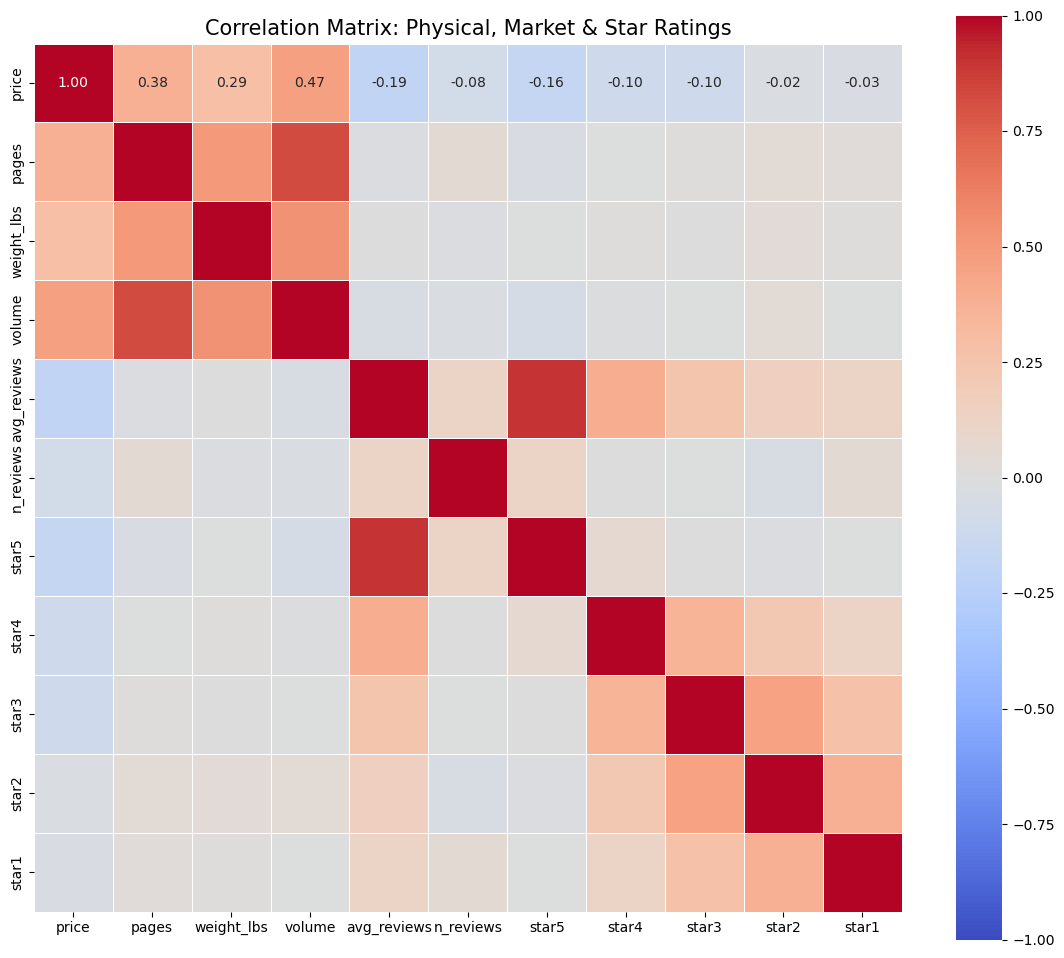


Độ tương quan với giá (Price):
price          1.000000
volume         0.466423
pages          0.381034
weight_lbs     0.285384
star2         -0.023857
star1         -0.032015
n_reviews     -0.084024
star4         -0.102307
star3         -0.103410
star5         -0.164448
avg_reviews   -0.193721
Name: price, dtype: float64


In [144]:
df_corr = Amazon_books_Q1[cols_numeric].dropna()

print(f"Số lượng mẫu dữ liệu sau khi làm sạch: {len(df_corr)}")

# 5. Vẽ Heatmap (Chỉnh lại kích thước lớn hơn chút vì nhiều cột hơn)
if len(df_corr) > 0:
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        df_corr.corr(numeric_only=True),
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        vmin=-1, vmax=1,
        linewidths=0.5,
        square=True
    )
    plt.title('Correlation Matrix: Physical, Market & Star Ratings', fontsize=15)
    plt.show()

    # (Optional) Xem tương quan với giá
    print("\nĐộ tương quan với giá (Price):")
    print(df_corr.corr()['price'].sort_values(ascending=False))
else:
    print("Dữ liệu bị trống. Hãy kiểm tra lại bước xử lý 'unknown' hoặc NaN.")

**1. Đặc tính vật lý (Physical Attributes) - Động lực chính của giá**
- Các yếu tố vật lý có mối tương quan dương (positive correlation) mạnh nhất với giá bán, theo thứ tự giảm dần:

- Volume (0.47): Kích thước tổng thể (Dài x Rộng x Cao) là yếu tố ảnh hưởng mạnh nhất. Một cuốn sách "to xác" (cồng kềnh) thường được định giá cao hơn.

- Pages (0.38): Số lượng trang đứng thứ hai. Điều này phản ánh chi phí biên tập và in ấn.

- Weight (0.29): Cân nặng có ảnh hưởng nhưng yếu hơn Volume và Pages.

=> Insight: Khách hàng (hoặc nhà xuất bản) dường như định giá dựa trên "độ hoành tráng" (visual size) nhiều hơn là "độ nặng" (density) thực tế.

**2. Tín hiệu thị trường & Đánh giá (Market & Feedback) - Nghịch lý về giá**
Có một mối tương quan âm (negative correlation) thú vị giữa Giá và Sự hài lòng của khách hàng:

- Avg Reviews (-0.19) & Star 5 (-0.16): Giá càng cao, điểm đánh giá trung bình và tỷ lệ 5 sao càng có xu hướng giảm.

=> ý giải 1 (Kỳ vọng cao): Khi phải trả nhiều tiền (ví dụ $50 so với $10), độc giả sẽ khắt khe hơn. Một lỗi nhỏ ở sách đắt tiền dễ dẫn đến việc bị trừ điểm hơn là ở sách rẻ.

=> Lý giải 2 (Sách chuyên khảo): Sách giá cao thường là sách kỹ thuật/giáo trình khó (Technical books), loại sách này khó đọc và kén người hơn tiểu thuyết, dẫn đến rating thường thấp hơn.

- N_reviews (-0.08): Gần như không có tương quan. Giá cao hay thấp không cản trở việc người ta để lại bình luận (số lượng), nhưng nó ảnh hưởng đến nội dung bình luận (chất lượng điểm số).

**3. Why worth investigating? (Tại sao điều này quan trọng?)**
- Tâm lý khách hàng: Dữ liệu cho thấy "Kích thước" (Volume) tác động đến giá mạnh hơn "Độ dày nội dung" (Pages). Một cuốn sách khổ to, dàn trang thoáng có thể bán giá tốt hơn một cuốn sách khổ nhỏ nhưng dày đặc chữ.

-Kỳ vọng khi xuất bản sách: Các tác giả bán sách giá cao cần hiểu rằng họ sẽ đối mặt với những độc giả khó tính hơn (ít 5 sao hơn).

**4. Thực tế**
=> Publishers: Nếu muốn tăng giá bán, hãy cân nhắc tăng kích thước khổ sách (Volume) thay vì chỉ tăng độ dày giấy hoặc số trang, vì Volume có hệ số tương quan cao nhất (0.48).

=> Marketing: Với sách giá cao, cần tập trung vào việc chứng minh giá trị nội dung để giảm thiểu tác động tiêu cực lên Rating (Avg Reviews).

### **Question 2: Độ dày của cuốn sách (số trang) có ảnh hưởng tới sự đánh giá của độc giả không?**

In [145]:
Amazon_books_Q2 = Amazon_books.copy()

### Preprocessing

In [146]:
# Kiểm tra phần trăm bị thiếu ở 2 cột pages và avg_reviews
for col in ['pages', 'avg_reviews']:
    missing_ratio = Amazon_books_Q2[col].isnull().mean()
    print(f"Missing Ratio in '{col}': {missing_ratio:.2%}")
    


Missing Ratio in 'pages': 1.08%
Missing Ratio in 'avg_reviews': 0.00%


In [147]:
# Fill 'pages' bằng trung vị (median) để tránh outlier ảnh hưởng
Amazon_books_Q4 = Amazon_books_Q2.copy() # Tạo bản sao để không ảnh hưởng câu trước
Amazon_books_Q4['pages'] = Amazon_books_Q4['pages'].fillna(Amazon_books_Q4['pages'].median())


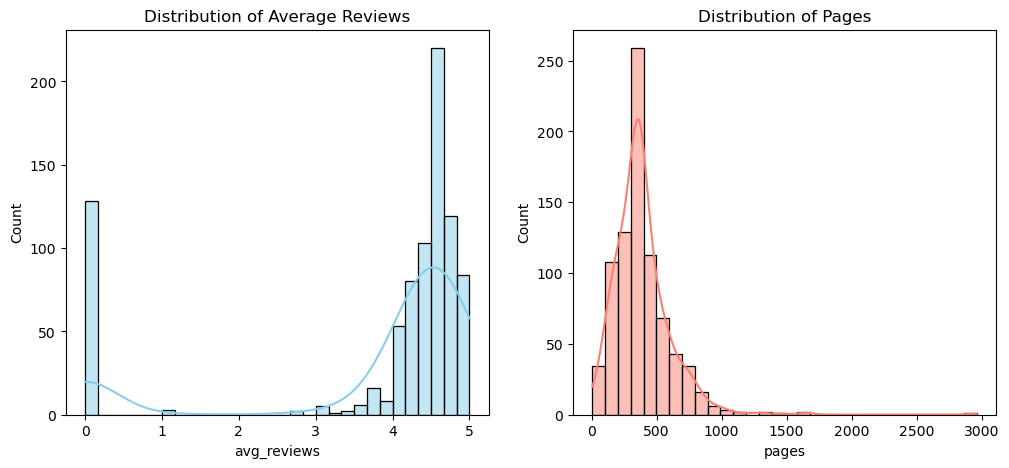

In [148]:
# Phân phối cột avg_reviews và cột pages
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(Amazon_books_Q2['avg_reviews'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Average Reviews')
plt.subplot(1, 2, 2)
sns.histplot(Amazon_books_Q2['pages'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Pages')
plt.show()


In [149]:
# Binning (Tạo nhóm độ dài)
def categorize_length(pages):
    if pages < 500:
        return 'Short (< 500)'
    elif 500 <= pages < 1000:
        return 'Medium (500-1000)'
    else:
        return 'Long (> 1000)'


Amazon_books_Q4['Length_Category'] = Amazon_books_Q4['pages'].apply(categorize_length)

# Sắp xếp thứ tự category để vẽ biểu đồ cho đẹp
length_order = ['Short (< 500)', 'Medium (500-1000)', 'Long (> 1000)']
Amazon_books_Q4['Length_Category'] = pd.Categorical(Amazon_books_Q4['Length_Category'], categories=length_order, ordered=True)

print("Đã tạo xong cột 'Length_Category'.")
print(Amazon_books_Q4['Length_Category'].value_counts().sort_index())

Đã tạo xong cột 'Length_Category'.
Short (< 500)        652
Medium (500-1000)    167
Long (> 1000)         11
Name: Length_Category, dtype: int64


### Preprocessing
1.  **Handling Missing Values:** Điền khuyết dữ liệu cột `pages` bằng trung vị (median) để tránh outlier làm lệch kết quả.
2.  **Binning (Phân nhóm):** Chia sách thành 4 nhóm độ dài để dễ so sánh:
    * Short (< 500 trang)
    * Medium (500 - 1000 trang)
    * Long (600 - 900 trang)
    * Long (> 1000 trang)
3. **Tạo cột:** Để tính số lương ở từng nhóm

--- Thống kê theo độ dài sách ---
     Length_Category  avg_reviews   n_reviews       price
0      Short (< 500)     3.697393  263.780675   38.287971
1  Medium (500-1000)     4.094012  301.616766   67.227988
2      Long (> 1000)     4.090909  577.363636  145.270909


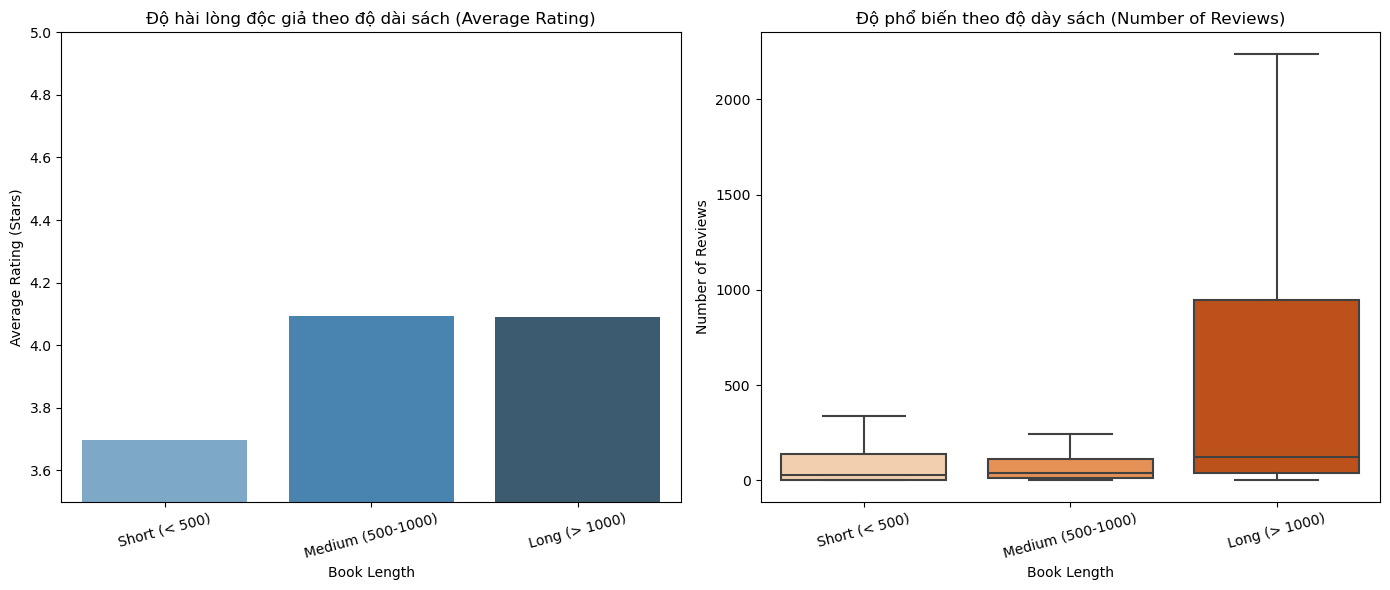

In [150]:
# 1. Tính toán thống kê
summary = Amazon_books_Q4.groupby('Length_Category', observed=False).agg({
    'avg_reviews': 'mean',
    'n_reviews': 'mean',   
    'price': 'mean'       
}).reset_index()

print("--- Thống kê theo độ dài sách ---")
print(summary)

# 2. Trực quan hóa 
plt.figure(figsize=(14, 6))

# Biểu đồ 1: Sự hài lòng (Rating) theo độ dài
plt.subplot(1, 2, 1)
sns.barplot(x='Length_Category', y='avg_reviews', data=summary, palette='Blues_d')
plt.title('Độ hài lòng độc giả theo độ dài sách (Average Rating)')
plt.ylim(3.5, 5.0) # Zoom vào khoảng điểm thực tế để thấy sự chênh lệch rõ hơn
plt.ylabel('Average Rating (Stars)')
plt.xlabel('Book Length')
plt.xticks(rotation=15)

# Biểu đồ 2: Độ phổ biến (Review Count) theo độ dày cuốn sách
plt.subplot(1, 2, 2)
sns.boxplot(x='Length_Category', y='n_reviews', data=Amazon_books_Q4, palette='Oranges', showfliers=False)
plt.title('Độ phổ biến theo độ dày sách (Number of Reviews)')
plt.ylabel('Number of Reviews')
plt.xlabel('Book Length')
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

### Động lực & Lợi ích
* **Chiến lược nội dung:** Giúp tác giả quyết định độ dài phù hợp cho tác phẩm của mình để tối ưu hóa trải nghiệm người đọc.
* **Phá bỏ định kiến:** Kiểm chứng giả thuyết liệu sách quá dài có khiến độc giả "ngán" và chấm điểm thấp hay không.


### Phương pháp phân tích
* Sử dụng phương pháp **Aggregation (Gom nhóm)**: Groupby theo `Length_Category` và tính trung bình rating (`avg_reviews`).
* Vẽ biểu đồ **Bar Chart** để so sánh rating giữa các nhóm.
* Vẽ biểu đồ **Box Plot** để xem phân phối số lượng review (độ phổ biến) theo độ dài.

### Kết quả
* **Về sự hài lòng:** Sách thuộc nhóm **Long và Medium** có điểm đánh giá trung bình cao nhất và cao ngang nhau. Điều này cho thấy độc giả Amazon thường đánh giá cao những cuốn sách dày, có nội dung sâu sắc.
* **Về độ phổ biến:** Nhóm sách **Long** có số lượng review nhiều nhất, chứng tỏ đây là độ dài dễ tiếp cận đại chúng nhất.

### **Question 3: Phân tích sự khác biệt giữa nhóm sách bị đánh giá thấp (Low Rated) và cao (High Rated) dựa trên chỉ số "Giá trên mỗi trang" (Price per Page).**

- Câu hỏi này để làm rõ "Liệu có phải người đọc đánh giá thấp vì họ cảm thấy cuốn sách "quá đắt so với độ mỏng" của nó?"

In [151]:
Amazon_books_Q3 = Amazon_books.copy()

Text(0.5, 0, 'Average Reviews')

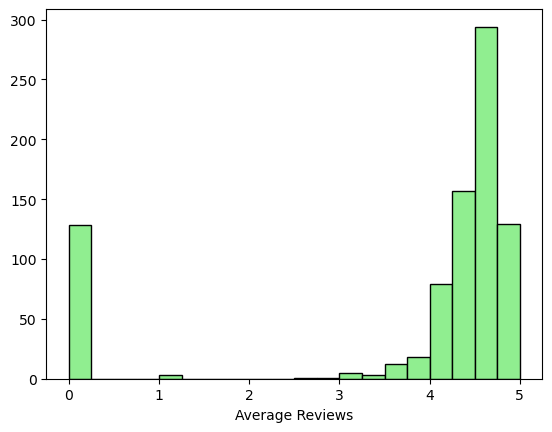

In [152]:
#Xem phân phối dữ liệu cột avg_reviews
plt.hist(Amazon_books_Q3['avg_reviews'].dropna(), bins=20, color='lightgreen', edgecolor='black')
plt.xlabel('Average Reviews')

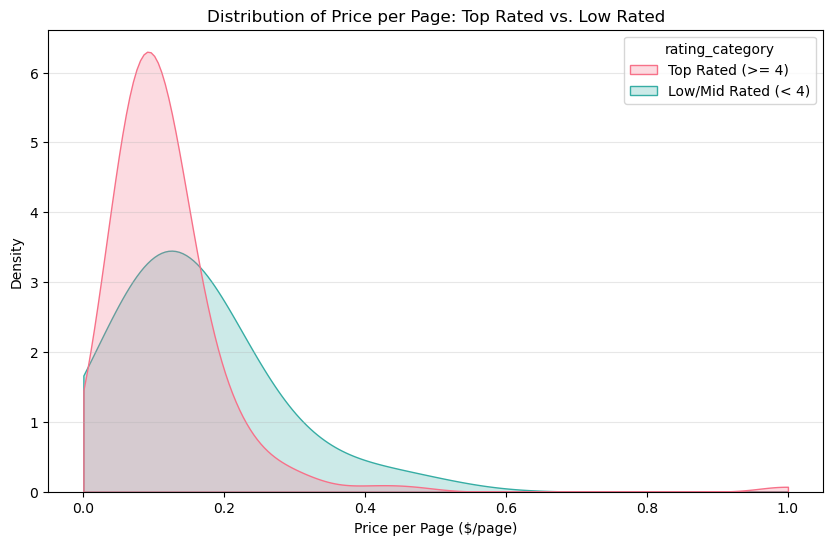

--- TRUNG BÌNH GIÁ TRÊN MỖI TRANG ---
                         mean       50%       max
rating_category                                  
Low/Mid Rated (< 4)  0.170504  0.130286  2.376108
Top Rated (>= 4)     0.123506  0.100311  1.729759


In [153]:
# Loại bỏ dòng không thể tính Price per Page
Amazon_books_Q3 = Amazon_books_Q3.dropna(subset=['price', 'pages'])
Amazon_books_Q3 = Amazon_books_Q3[Amazon_books_Q3['pages'] > 0]

# 1.Tạo cột Price per Page
# (Lưu ý: Đảm bảo cột pages và price đã sạch và là số dương để tránh chia cho 0)
Amazon_books_Q3['price_per_page'] = Amazon_books_Q3['price'] / Amazon_books_Q3['pages']

# 2. Phân nhóm 
# Nhóm Thấp: < 4 
# Nhóm Cao: >= 4.0
def categorize_rating(score):
    if score < 4:
        return 'Low/Mid Rated (< 4)'
    elif score >= 4:
        return 'Top Rated (>= 4)'
    else:
        return 'Average'

Amazon_books_Q3['rating_category'] = Amazon_books_Q3['avg_reviews'].apply(categorize_rating)

# Lọc bỏ nhóm Average để so sánh 2 cực đối lập cho rõ
comparison_df = Amazon_books_Q3[Amazon_books_Q3['rating_category'] != 'Average'].copy()

# Xử lý vô cực hoặc NaN nếu có (do chia cho 0)
comparison_df.replace([np.inf, -np.inf], np.nan, inplace=True)
comparison_df.dropna(subset=['price_per_page'], inplace=True)

# 3. Trực quan hóa: KDE Plot (Biểu đồ mật độ)
plt.figure(figsize=(10, 6))

sns.kdeplot(data=comparison_df, x='price_per_page', hue='rating_category', 
            fill=True, palette='husl', common_norm=False, clip=(0, 1.0)) 


plt.title('Distribution of Price per Page: Top Rated vs. Low Rated')
plt.xlabel('Price per Page ($/page)')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.3)
plt.show()

# 4. Thống kê con số cụ thể
print("--- TRUNG BÌNH GIÁ TRÊN MỖI TRANG ---")
print(comparison_df.groupby('rating_category')['price_per_page'].describe()[['mean', '50%', 'max']])

### 
* **Phân tích hành vi tiêu dùng:** Xác định xem độc giả Amazon coi trọng "Giá trị đồng tiền" (Value for money) như thế nào.
* **Chiến lược định giá:** Giúp tác giả và nhà xuất bản tránh việc định giá quá cao so với độ dày cuốn sách, điều có thể dẫn đến phản ứng ngược (rating thấp) từ người mua.

### Preprocessing
1.  **Data Cleaning:** Loại bỏ các dữ liệu nhiễu (sách có số trang = 0 hoặc thiếu giá tiền).
2.  **Feature Engineering:** Tạo chỉ số `price_per_page = price / pages` để chuẩn hóa giá sách.
3.  **Segmentation (Phân khúc):** Chia sách thành 2 nhóm dựa trên sự hài lòng của độc giả:
    * **Low/Mid Rated:** Điểm đánh giá < 4.0 sao.
    * **Top Rated:** Điểm đánh giá $\ge$ 4.0 sao.

### Phương pháp phân tích
* Sử dụng **KDE Plot (Kernel Density Estimate)** để so sánh phân phối mật độ giá/trang giữa hai nhóm.
* So sánh các chỉ số thống kê trung tâm (**Mean, Median**) để tìm ra sự chênh lệch rõ ràng.

### Results & Interpretation
Dựa trên biểu đồ và bảng thống kê, chúng tôi có các quan sát thú vị:

* **Nghịch lý về giá:**
    * Nhóm **Low/Mid Rated** lại có chỉ số giá/trang trung bình **cao hơn** (`~$0.17/page`).
    * Nhóm **Top Rated** có chỉ số giá/trang trung bình **thấp hơn** (`~$0.12/page`).
* **Kết luận:** Có một mối tương quan nghịch biến. Những cuốn sách có giá thành trên mỗi trang rẻ hơn thường nhận được đánh giá cao hơn.
* **Lý giải:** Độc giả có xu hướng cảm thấy "hời" (good deal) khi mua những cuốn sách dày với mức giá hợp lý. Ngược lại, những cuốn sách mỏng nhưng giá cao (high price per page) dễ khiến người đọc cảm thấy không xứng đáng với số tiền bỏ ra, dẫn đến việc họ chấm điểm khắt khe hơn.

### **Question 4: Mô hình dự đoán giá của sách**

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

#### Preprocessing

In [155]:
# Thay giá trị nan bằng unknown ở cột price
Amazon_books_Q4 = Amazon_books.copy()

In [156]:
# Các kiểu dữ liệu của các cột ở feature và target
print(Amazon_books_Q4[features + [target]].dtypes)

pages          float64
weight_lbs     float64
volume         float64
avg_reviews    float64
n_reviews        int64
star5          float64
star4          float64
star3          float64
star2          float64
star1          float64
price          float64
dtype: object


In [157]:
# Kiểm tra phần trăm thiếu ở cột features và target 
for col in features + [target]:
    missing_ratio = Amazon_books_Q4[col].isnull().mean()
    print(f"Missing Ratio in '{col}': {missing_ratio:.2%}")

Missing Ratio in 'pages': 1.08%
Missing Ratio in 'weight_lbs': 0.00%
Missing Ratio in 'volume': 0.00%
Missing Ratio in 'avg_reviews': 0.00%
Missing Ratio in 'n_reviews': 0.00%
Missing Ratio in 'star5': 0.00%
Missing Ratio in 'star4': 0.00%
Missing Ratio in 'star3': 0.00%
Missing Ratio in 'star2': 0.00%
Missing Ratio in 'star1': 0.00%
Missing Ratio in 'price': 13.01%


In [ ]:
# 1. SETUP DATA 
# Tách dữ liệu: Nhóm có giá (để train) và nhóm chưa có giá (để predict sau cùng)
# Thay giá trị trung vị với cột pages
Amazon_books_Q4['pages'] = Amazon_books_Q4['pages'].fillna(Amazon_books_Q4['pages'].median())

data_train = Amazon_books_Q4[Amazon_books_Q4['price'].notna()].copy()
data_predict = Amazon_books_Q4[Amazon_books_Q4['price'] == 'unknown'].copy()

# Chuyển đổi cột price sang số thực
data_train['price'] = pd.to_numeric(data_train['price'], errors='coerce')

X = data_train[features]
y = np.log1p(data_train['price'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [159]:
# 2. TRAIN MODELS
# Model 1: Linear Regression (Baseline)
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Model 2: Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

**Lí do chọn 2 model này?**
Việc lựa chọn 2 mô hình đại diện cho hai hướng tiếp cận khác nhau để so sánh :
1.  **Linear Regression (Baseline):** Đây là mô hình cơ sở đơn giản nhất. Nhóm chọn nó để kiểm tra xem mối quan hệ giữa "độ dày/cân nặng" và "giá tiền" có phải là tuyến tính hay không. Nó giúp thiết lập một mức chuẩn (baseline score) để đánh giá các mô hình phức tạp hơn.
2.  **Random Forest Regressor:** Việc cho rằng giá sách chịu ảnh hưởng bởi các yếu tố phi tuyến tính (ví dụ: sách rất mỏng nhưng rating cao vẫn có thể đắt). Random Forest được chọn vì khả năng xử lý tốt các mối quan hệ phức tạp, chống nhiễu (robust to outliers) và giảm thiểu hiện tượng Overfitting so với Decision Tree đơn lẻ.

### Preprocessing
1.  **Handling Missing Values:**
    * `price` (Target): Loại bỏ các dòng thiếu giá trị (`NaN`) vì đây là biến mục tiêu cần dự đoán (~13% dữ liệu).
    * `pages` (Feature): Điền các giá trị thiếu bằng **Trung vị (Median)** để tránh bị ảnh hưởng bởi các cuốn sách quá dày hoặc quá mỏng (outliers).
2.  **Log Transformation:** Áp dụng hàm `np.log1p` cho cột `price`. Vì giá sách thường có phân phối lệch phải (nhiều sách rẻ, ít sách cực đắt), việc chuyển sang log giúp phân phối chuẩn hơn, giúp Linear Regression hoạt động hiệu quả hơn.
3.  **Feature Selection:** Sử dụng các đặc trưng: `pages`, `weight_lbs`, `volume`, `avg_reviews`, `n_reviews` và các cột tỷ lệ sao (`star5`...`star1`).

--- BẢNG SO SÁNH HIỆU QUẢ (TRUNG BÌNH 5-FOLD) ---
               Model       MAE      RMSE  R2 Score
0  Linear Regression  0.454464  0.630239  0.241129
1      Random Forest  0.406982  0.566809  0.386103


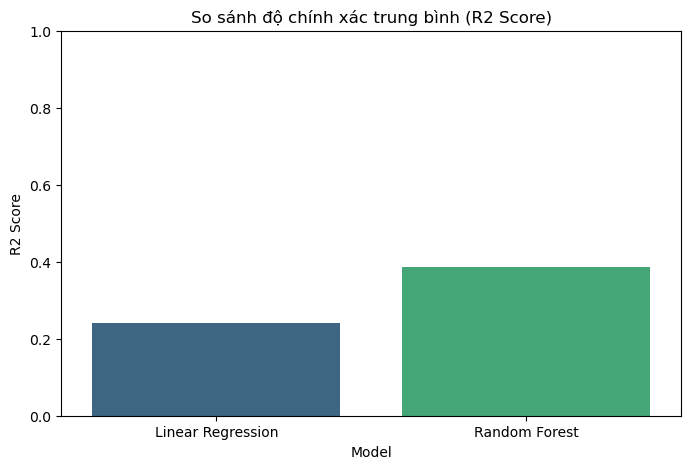

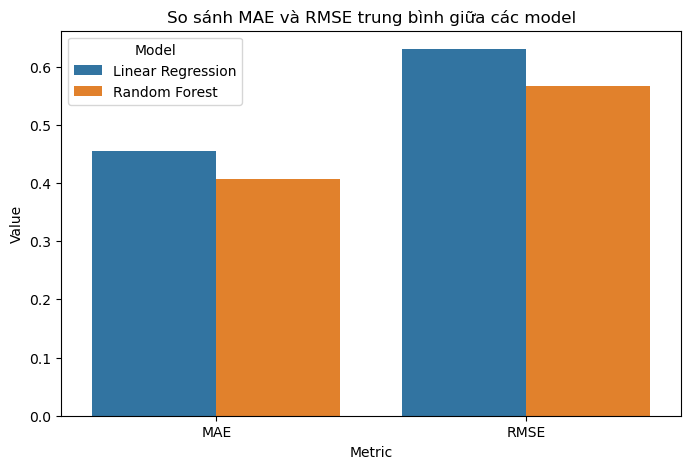

In [ ]:
# 3. EVALUATE & COMPARE
from sklearn.model_selection import cross_validate, KFold


# Chạy 5 lần (splits)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2'
}

# Danh sách các model cần kiểm tra
models = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest", RandomForestRegressor(random_state=42)) 
]

results = []


for name, model in models:
    # Chạy K-Fold
    cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring)
    
    # Tính giá trị trung bình của 5 lần chạy 
    mean_mae = -cv_results['test_MAE'].mean()
    mean_rmse = -cv_results['test_RMSE'].mean()
    mean_r2 = cv_results['test_R2'].mean()
    
    results.append({
        "Model": name, 
        "MAE": mean_mae, 
        "RMSE": mean_rmse, 
        "R2 Score": mean_r2
    })

df_results = pd.DataFrame(results)
print("BẢNG SO SÁNH HIỆU QUẢ (TRUNG BÌNH 5-FOLD)")
print(df_results)

# Vẽ biểu đồ so sánh R2
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="R2 Score", data=df_results, palette="viridis")
plt.title("So sánh độ chính xác trung bình (R2 Score)")
plt.ylim(0, 1)
plt.show()

# Vẽ biểu đồ MAE và RMSE
metrics_df = df_results.melt(
    id_vars="Model",
    value_vars=["MAE", "RMSE"],
    var_name="Metric",
    value_name="Value"
)

plt.figure(figsize=(8,5))
sns.barplot(x="Metric", y="Value", hue="Model", data=metrics_df)
plt.title("So sánh MAE và RMSE trung bình giữa các model")
plt.show()

### Motivation & Model Selection Strategy
* **Thực tiễn:** Giá sách trên Amazon biến động rất phức tạp. Việc xây dựng một mô hình dự đoán giúp người bán (sellers) định giá sản phẩm hợp lý dựa trên các thông số kỹ thuật, tránh định giá quá thấp (mất lãi) hoặc quá cao (không bán được).

### Analysis Method
* **Cross-Validation:** Thay vì chỉ chia train/test một lần, chúng tôi sử dụng kỹ thuật **K-Fold Cross Validation (k=5)**. Dữ liệu được chia thành 5 phần ngẫu nhiên, mô hình được huấn luyện và kiểm thử 5 lần. Kết quả cuối cùng là trung bình cộng, giúp đánh giá độ ổn định và khách quan của mô hình.
* **Evaluation Metrics:** Sử dụng 3 chỉ số:
    * **MAE (Mean Absolute Error):** Sai số tuyệt đối trung bình (dễ hiểu về mặt giá cả).
    * **RMSE (Root Mean Squared Error):** Phạt nặng các dự đoán sai lệch lớn.
    * **R2 Score:** Đo lường mức độ biến thiên của giá mà mô hình giải thích được.

### Results & Interpretation
Dưới đây là kết quả trung bình sau khi chạy 5-Fold Cross Validation:

| Model | MAE (Log scale) | RMSE (Log scale) | R2 Score |
| :--- | :--- | :--- | :--- |
| **Linear Regression** | 0.454 | 0.630 | 0.241 |
| **Random Forest** | **0.407** | **0.567** | **0.386** |

**Nhận xét:**
* **Random Forest vượt trội hơn:** Với $R^2 \approx 0.39$, Random Forest giải thích được gần 40% sự biến thiên của giá sách, cao hơn đáng kể so với Linear Regression ($R^2 \approx 0.24$). Điều này xác nhận giả thuyết rằng việc định giá sách phụ thuộc vào các mối quan hệ phi tuyến tính phức tạp giữa các thông số.
* **Hạn chế:** Mặc dù Random Forest tốt hơn, nhưng $R^2$ chưa đạt mức cao (>0.7). Điều này cho thấy các thông số vật lý (trang, nặng) và review chỉ đóng góp một phần vào giá. Giá sách thực tế còn chịu ảnh hưởng lớn bởi các yếu tố định tính không có trong dataset như: **Thương hiệu tác giả, Uy tín nhà xuất bản, và Giá trị nghệ thuật/hàn lâm** .